# Warping of images

In [3]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

(1776, 1200, 3)


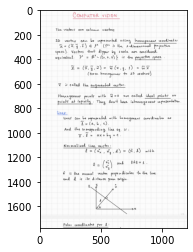

In [4]:
# Load image
img = cv.imread(cv.samples.findFile("../../assets/handwritten.jpg"))
print(img.shape)

# Ploting the image requires to transform RGB to BGR
plt.imshow(img[:,:,::-1])
plt.show()

## Affine transformations

In [5]:
# Points at origin and at destination.
src_points = np.array(
    [[0, 0], 
     [img.shape[1] - 1, 0], 
     [0, img.shape[0] - 1]]
).astype(np.float32)

dst_points = np.array(
    [[0, img.shape[1] * 0.20], 
     [img.shape[1] * 0.90, img.shape[0] * 0.25], 
     [img.shape[1] * 0.15, img.shape[0] * 0.8]]
).astype(np.float32)

print("Points at origin:\n", src_points)
print("Points at destination:\n", dst_points)

Points at origin:
 [[   0.    0.]
 [1199.    0.]
 [   0. 1775.]]
Points at destination:
 [[   0.   240. ]
 [1080.   444. ]
 [ 180.  1420.8]]


In [6]:
# Computing warping matrix
warp_mat = cv.getAffineTransform(src_points, dst_points)
print("Warp matrix:\n", warp_mat)

Warp matrix:
 [[9.00750626e-01 1.01408451e-01 0.00000000e+00]
 [1.70141785e-01 6.65239464e-01 2.40000000e+02]]


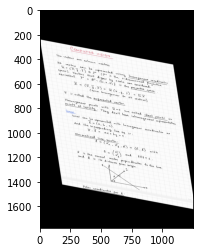

In [7]:
# Computing warped image according to the matrix. In this code, I can form my
# own matrix, and then apply the affine transformation without go through the
# definition of points.
warp_img = cv.warpAffine(img, warp_mat, (img.shape[1] + 50, img.shape[0]))
plt.imshow(warp_img[:,:,::-1])
plt.show()

## Rotations

In [8]:
center = (img.shape[1] / 2, img.shape[0] / 2)
angle = 45
scale = 0.70
rot_mat = cv.getRotationMatrix2D(center, angle, scale)

print("Rotation matrix:\n", rot_mat)

Rotation matrix:
 [[ 4.94974747e-01  4.94974747e-01 -1.36522423e+02]
 [-4.94974747e-01  4.94974747e-01  7.45447273e+02]]


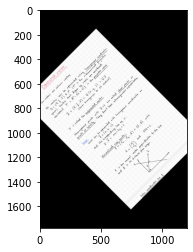

In [9]:
img_dst = cv.warpAffine(img, rot_mat, (img.shape[1], img.shape[0]))

plt.imshow(img_dst[:, :, ::-1])
plt.show()

## Perspective transformations

In [10]:
# Points at origin and at destination
src_points = np.array([
    [0, 0],
    [0, img.shape[1] - 1],
    [img.shape[0] - 1, 0],
    [img.shape[0] - 1, img.shape[1] - 1],
]).astype(np.float32)

dst_points = np.array([
    [100, 100],
    [20, img.shape[1] * 0.70],
    [img.shape[0] * 0.90, 0],
    [img.shape[0] * 0.95, img.shape[1] * 0.80],
]).astype(np.float32)

print("Points at origin:\n", src_points)
print("Points at destination:\n", dst_points)

Points at origin:
 [[   0.    0.]
 [   0. 1199.]
 [1775.    0.]
 [1775. 1199.]]
Points at destination:
 [[ 100.   100. ]
 [  20.   840. ]
 [1598.4    0. ]
 [1687.2  960. ]]


In [11]:
# Homography computation
H, _ = cv.findHomography(src_points, dst_points)
print(H)

[[ 6.47892815e-01 -6.82174858e-02  1.00000000e+02]
 [-5.63380282e-02  5.54381859e-01  1.00000000e+02]
 [-1.22795427e-04 -7.47608632e-05  1.00000000e+00]]


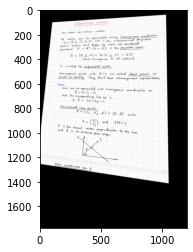

In [12]:
# Warping the image according to homography
img_warp = cv.warpPerspective(img, H, (img.shape[1], img.shape[0]))

plt.imshow(img_warp[:,:,::-1])
plt.show()

## Non-linear transformations

This is a warping by a non-linear function. This warping does not resembles the
real behavior in a traditional warping.

First step: resize and translate


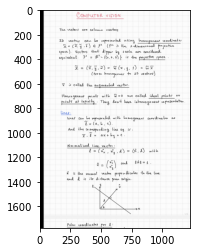

Second step: warp


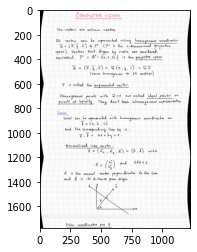

(1776, 1230, 3)
Third step: rotate


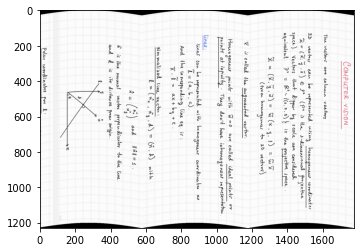

In [13]:
height = 30

# First we need to translate the image by a height
mat_trans = np.array([
    [1, 0, height],
    [0, 1, 0]
]).astype(np.float32)

img_trans = cv.warpAffine(img, mat_trans, (img.shape[1] + height, img.shape[0]))

print("First step: resize and translate")
plt.imshow(img_trans[:, :, ::-1])
plt.show()

# Now we warp the image according to a non-linear function
img_dst = np.zeros((img.shape[0], img.shape[1] + height, img.shape[2]),
                   dtype=img.dtype)

for i in range(img_trans.shape[0]):
    for j in range(img_trans.shape[1]):
        offset_x = int(np.abs(
            height * np.sin(2 * np.pi * i / (img.shape[1]))))
        
        if j + offset_x < img_trans.shape[1]:
            img_dst[i, j] = img_trans[i, j + offset_x]
        else:
            img_dst[i, j] = 0

print("Second step: warp")            
plt.imshow(img_dst[:, :, ::-1])
plt.show()

print(img_dst.shape)

# We apply a rotation of the image
img_rot = cv.rotate(img_dst, cv.ROTATE_90_CLOCKWISE)

print("Third step: rotate")            
plt.imshow(img_rot[:, :, ::-1])
plt.show()

## Grid model

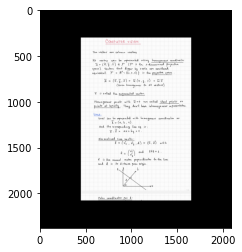

In [14]:
# Enlarge the image
excess_height = img.shape[1] * 1 // 4
excess_width = img.shape[0] * 1// 4
img_resize = cv.copyMakeBorder(img, excess_height, excess_height, excess_width,
                               excess_width, borderType=cv.BORDER_CONSTANT,
                               value=(0, 0, 0))

plt.imshow(img_resize[:, :, ::-1])
plt.show()

In [27]:
def apply_mesh(mesh, img):
    x_mesh_pert = mesh[:, 0].reshape(img.shape[0], 
                                     img.shape[1]).astype(np.int32)
    y_mesh_pert = mesh[:, 1].reshape(img.shape[0], 
                                     img.shape[1]).astype(np.int32)
    
    x_trans = np.zeros(shape=(img.shape[0], img.shape[1]))
    y_trans = np.zeros(shape=(img.shape[0], img.shape[1]))
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            x_coord = x_mesh_pert[i, j]
            y_coord = y_mesh_pert[i, j]
            if 0 <= x_coord < x_trans.shape[0] and \
                    0 <= y_coord < x_trans.shape[1]:
                x_trans[x_coord, y_coord] = j
                y_trans[x_coord, y_coord] = i            
    
    perturbed_image = cv.remap(img, x_trans.astype(np.float32), 
                               y_trans.astype(np.float32), cv.INTER_LINEAR)
    return perturbed_image


def change_coordinates(point, height):
    new_x = height - 1 - point[1]
    new_y = point[0]
    return np.array([new_x, new_y])


def correct_image(img, kernel_size):
    kernel = np.ones(shape=(kernel_size, kernel_size)) / (kernel_size ** 2)
    corrected_img = cv.filter2D(img, ddepth=-1, kernel=kernel)
    return corrected_img


def show_mesh(mesh):
    # ==========================
    # To show the perturbed mesh
    # ==========================
    plt.scatter(mesh[:, 0], mesh[:, 1], 
                c="black",
                marker="o",
                alpha=1, 
                s=0.5)
    ax = plt.gca()
    ax.set_aspect("equal", adjustable="box")
    plt.show()
    # ==========================


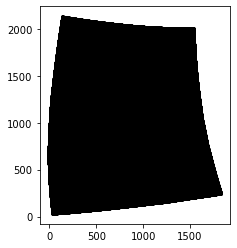

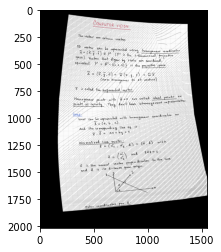

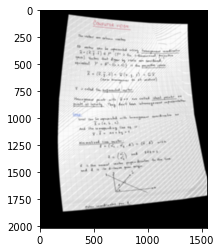

True

In [30]:
def construct_random_mesh(width, height, max_rand_mov, max_str, curved_norm):
    """Source code taken and adapted from 
    https://github.com/mhashas/Document-Image-Unwarping-pytorch/issues/7"""
    
    x_axis = np.arange(0, width, 1)
    y_axis = np.arange(0, height, 1)
    x_mesh, y_mesh = np.meshgrid(x_axis, y_axis)

    # Generates the mesh without modifications, only the points
    perturbed_mesh = np.transpose(np.asarray([x_mesh.flatten("C"), 
                                              y_mesh.flatten("C")[::-1]]))
    
    n_variations = np.random.randint(max_rand_mov)
    for _ in range(n_variations):
        # Choose a vertex at random
        rnd_point_idx = np.random.randint(perturbed_mesh.shape[0])
        rnd_point = perturbed_mesh[rnd_point_idx, :]
        
        # This vector gives the direction and strength of the deformation
        v = (np.random.rand(1, 2) - 0.5) * max_str
        
        # Compute the distance from every point to the line rnd_point + t * v
        difference = rnd_point - perturbed_mesh
        cross_v_difference = np.cross(v, difference)
        d = np.abs(cross_v_difference) / np.linalg.norm(v, ord=2)
        
        # Choice at random if perform curved or linear deformation
        is_linear = np.random.rand()
        if is_linear < 0.7:
            alpha = np.random.uniform(100, 150)
            w = alpha / (d + alpha)
        else:
            alpha = np.random.uniform(low=1, high=2)
            w = 1 - np.power(d / curved_norm, alpha)
            
        # Resize w to match element wise multiplication
        reshaped_w = w.reshape((w.shape[0], 1))
        duplicated_w = np.append(reshaped_w, reshaped_w, axis=1)
        
        # Make modification to the mesh
        perturbed_mesh = perturbed_mesh + duplicated_w * v
        
    return perturbed_mesh

# Syntetic deformation params
MAX_STRENGTH = 20
MAX_RANDOM_MOV = 19
CURVED_NORMALIZER = 200

mesh = construct_random_mesh(img_resize.shape[1], img_resize.shape[0],
                             MAX_RANDOM_MOV, MAX_STRENGTH, CURVED_NORMALIZER)
show_mesh(mesh)

changed_mesh = np.apply_along_axis(change_coordinates, 1, mesh, 
                                   img_resize.shape[0])

perturbed_image = apply_mesh(changed_mesh, img_resize)
plt.imshow(perturbed_image[:, :, ::-1])
plt.show()

corrected_image = perturbed_image #correct_image(perturbed_image, 13)
plt.imshow(corrected_image[:, :, ::-1])
plt.show()

cv.imwrite("../../assets/handwritten_warped.jpg", corrected_image)

# Own perturbation

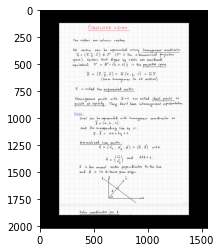

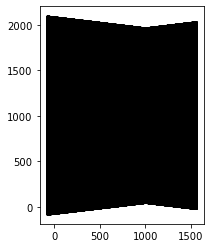

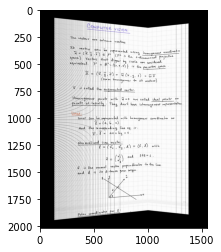

True

In [17]:
def curve(x, alpha, omega):
    return alpha * omega * abs(x) * np.exp(-alpha * abs(x))


def f(point, foc_len, obj_len, alpha, omega, scale):
    x = point[0] - 1000
    y = point[1] - 1000
    x_eval = curve(x, alpha, omega)
    return np.array([foc_len * scale * x / (obj_len - x_eval) + 1000, \
           foc_len * scale * y / (obj_len - x_eval) + 1000])


def construct_own_mesh(width, height, foc_len, obj_len, alpha, omega, scale):
    x_axis = np.arange(0, width, 1)
    y_axis = np.arange(0, height, 1)
    x_mesh, y_mesh = np.meshgrid(x_axis, y_axis)

    # Generates the mesh without modifications, only the points
    initial_mesh = np.transpose(np.asarray([x_mesh.flatten("C"), 
                                            y_mesh.flatten("C")[::-1]]))
    
    perturbed_mesh = np.apply_along_axis(f, 1, initial_mesh, foc_len, obj_len,
                                         alpha, omega, scale)
     
    return perturbed_mesh 

     
OMEGA = 3000
ALPHA = 0.000008
OBJ_LEN = 200
FOC_LEN = OBJ_LEN - 10
SCALE_FACTOR = 1


# Enlarge the image
excess_height = img.shape[1] * 1 // 10
excess_width = img.shape[0] * 1 // 10
img_resize = cv.copyMakeBorder(img, excess_height, excess_height, excess_width,
                               excess_width, borderType=cv.BORDER_CONSTANT,
                               value=(0, 0, 0))

plt.imshow(img_resize[:, :, ::-1])
plt.show()

# Perturb mesh
perturbed_mesh = construct_own_mesh(img_resize.shape[1], img_resize.shape[0], 
                                    FOC_LEN, OBJ_LEN, ALPHA, OMEGA, 
                                    SCALE_FACTOR)
show_mesh(perturbed_mesh)

# Change coordinate system
perturbed_mesh_coord = np.apply_along_axis(change_coordinates, 1,
                                           perturbed_mesh, img_resize.shape[0])

perturbed_image = apply_mesh(perturbed_mesh_coord, img_resize)
plt.imshow(perturbed_image)
plt.show()

cv.imwrite("../../assets/handwritten_warped.jpg", perturbed_image)


In [18]:
width = 3
height = 4

x_axis = np.arange(0, width, 1)
y_axis = np.arange(0, height, 1)

print("x_axis")
print(x_axis)

print("y_axis")
print(y_axis)

x_mesh, y_mesh = np.meshgrid(x_axis, y_axis)

print("x_mesh")
print(x_mesh)

print("y_mesh")
print(y_mesh)


print("x_mesh flatten")
print(x_mesh.flatten("C"))

print("y_mesh flatten")
print(y_mesh.flatten("C")[::-1])

# Generates the mesh without modifications, only the points
mesh = np.transpose(np.asarray([x_mesh.flatten("C"), 
                                y_mesh.flatten("C")[::-1]]))

print("mesh")
print(mesh)

print("==== HERE WE PERTURB THE MESH ====")

perturbed_mesh = np.apply_along_axis(change_coordinates, 1, mesh,
                                         height)

print("new_mesh")
print(perturbed_mesh)

x_mesh_pert = perturbed_mesh[:, 0].reshape(height, 
                                           width).astype(np.float32)
y_mesh_pert = perturbed_mesh[:, 1].reshape(height, 
                                           width).astype(np.float32)

print("x_mesh_pert")
print(x_mesh_pert)

print("y_mesh_pert")
print(y_mesh_pert)

x_axis
[0 1 2]
y_axis
[0 1 2 3]
x_mesh
[[0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]]
y_mesh
[[0 0 0]
 [1 1 1]
 [2 2 2]
 [3 3 3]]
x_mesh flatten
[0 1 2 0 1 2 0 1 2 0 1 2]
y_mesh flatten
[3 3 3 2 2 2 1 1 1 0 0 0]
mesh
[[0 3]
 [1 3]
 [2 3]
 [0 2]
 [1 2]
 [2 2]
 [0 1]
 [1 1]
 [2 1]
 [0 0]
 [1 0]
 [2 0]]
==== HERE WE PERTURB THE MESH ====
new_mesh
[[0 0]
 [0 1]
 [0 2]
 [1 0]
 [1 1]
 [1 2]
 [2 0]
 [2 1]
 [2 2]
 [3 0]
 [3 1]
 [3 2]]
x_mesh_pert
[[0. 0. 0.]
 [1. 1. 1.]
 [2. 2. 2.]
 [3. 3. 3.]]
y_mesh_pert
[[0. 1. 2.]
 [0. 1. 2.]
 [0. 1. 2.]
 [0. 1. 2.]]
